<a href="https://colab.research.google.com/github/YasinnSoylu/actt/blob/main/alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd
from pathlib import Path
from timm import create_model


%reload_ext autoreload
%autoreload 2
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 4.5 MB/s 
     |████████████████████████████████| 182 kB 54.4 MB/s 


In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
! unzip skin-cancer-mnist-ham10000.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10

In [3]:
csv_path = "/content/HAM10000_metadata.csv"
skin_df = pd.read_csv(csv_path)
skin_df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [4]:
path = Path('/content/')
Path.BASE_PATH = path
path.ls()

(#13) [Path('.config'),Path('hmnist_28_28_RGB.csv'),Path('hmnist_8_8_RGB.csv'),Path('ham10000_images_part_1'),Path('skin-cancer-mnist-ham10000.zip'),Path('HAM10000_images_part_2'),Path('HAM10000_images_part_1'),Path('kaggle.json'),Path('HAM10000_metadata.csv'),Path('hmnist_8_8_L.csv')...]

In [5]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease", # very early form of skin cancer 
    "bcc" : "basal cell carcinoma" , # basal-cell cancer or white skin cancer
    "bkl" : "benign keratosis-like lesions", # non-cancerous skin tumour
    "df" : "dermatofibroma", # non-cancerous rounded bumps 
    "mel" : "melanoma", # black skin cancer
    "nv" : "melanocytic nevi", # mole non-cancerous
    "vasc" : "vascular lesions", # skin condition
}
 

In [6]:
# returns only dx and image id column
img_to_class_dict = skin_df.loc[:, ["image_id", "dx"]] 
# returns columns as lists in a dict
img_to_class_dict = img_to_class_dict.to_dict('list')  
# returns a dict mapping image id to disease name
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } 
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [7]:
# path.stem returns the filename without suffix
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] 

In [13]:
dblock = DataBlock(
    # Designation the independent and dependent variables
    blocks = (ImageBlock, CategoryBlock), 
    # To get a list of those files,and returns a list of all of the images in that path
    get_items = get_image_files, 
    # Split our training and validation sets randomly
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    # We are telling fastai what function to call to create the labels in our dataset, in our case is independet variable
    get_y = get_label_from_dict,
    # DihedralItem all 4 90 deg roatations and for each: 
    #2 horizonntal flips -> 8 orientations
    item_tfms=[Resize(448), DihedralItem()],
    # Picks a random scaled crop of an image and resize it to size
    batch_tfms=RandomResizedCrop(size=32, min_scale=0.75, max_scale=1.0))

img_path = "/content/"
# create dataloader using img_path   
data= dblock.dataloaders(img_path, bs=64) # bs = batch size

In [14]:
learn = vision_learner(data, alexnet,  metrics=[accuracy])
learn.unfreeze()

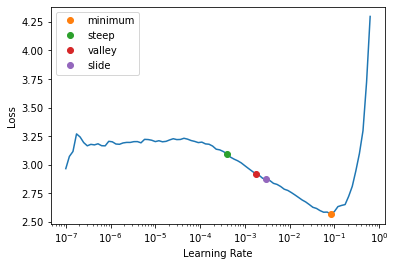

In [15]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide) )


In [16]:
learn.fit_one_cycle(5,lr_max=lrs.valley)


epoch,train_loss,valid_loss,accuracy,time
0,1.432240,1.291986,0.582626,05:12
1,0.861008,0.698503,0.737893,05:08
2,0.730933,0.689263,0.747129,05:07
3,0.654191,0.586703,0.774338,05:05
4,0.590710,0.532820,0.806540,05:02


In [17]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

                               precision    recall  f1-score   support

              Bowen's disease       0.58      0.45      0.51       144
         basal cell carcinoma       0.58      0.66      0.62       197
benign keratosis-like lesions       0.57      0.56      0.57       426
               dermatofibroma       1.00      0.02      0.04        45
             melanocytic nevi       0.89      0.94      0.92      2702
                     melanoma       0.63      0.49      0.55       446
             vascular lesions       0.74      0.67      0.70        46

                     accuracy                           0.81      4006
                    macro avg       0.71      0.54      0.56      4006
                 weighted avg       0.80      0.81      0.80      4006



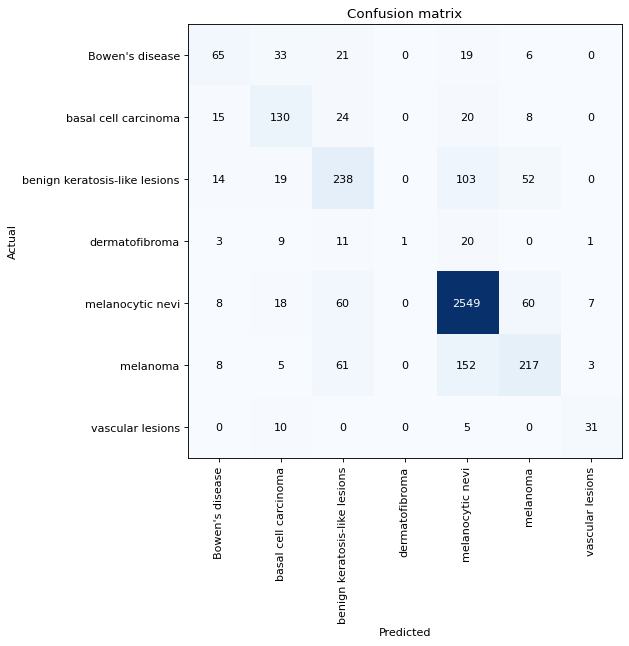

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

In [20]:
learn.fit_one_cycle(5,lr_max=lrs.slide)


epoch,train_loss,valid_loss,accuracy,time
0,0.762371,1.768386,0.544683,04:57
1,0.791828,0.924527,0.694708,04:59
2,0.709704,0.866233,0.746630,05:00
3,0.629152,0.584573,0.780080,04:59
4,0.577601,0.543280,0.796805,05:01


In [21]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

                               precision    recall  f1-score   support

              Bowen's disease       0.61      0.37      0.46       144
         basal cell carcinoma       0.60      0.62      0.61       197
benign keratosis-like lesions       0.56      0.56      0.56       426
               dermatofibroma       0.67      0.04      0.08        45
             melanocytic nevi       0.88      0.94      0.91      2702
                     melanoma       0.61      0.47      0.53       446
             vascular lesions       0.67      0.70      0.68        46

                     accuracy                           0.80      4006
                    macro avg       0.66      0.53      0.55      4006
                 weighted avg       0.78      0.80      0.79      4006



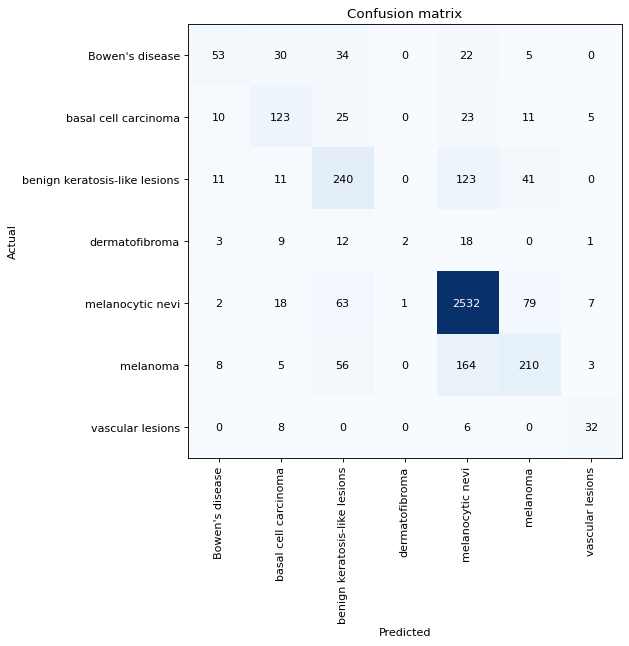

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

In [23]:
learn.fit_one_cycle(5,lr_max=lrs.steep)


epoch,train_loss,valid_loss,accuracy,time
0,0.602074,0.580501,0.786570,05:01
1,0.569994,0.662419,0.756116,05:17
2,0.557647,0.548905,0.811283,04:59
3,0.535912,0.495518,0.816775,05:01
4,0.514002,0.491680,0.821767,05:11


In [24]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

                               precision    recall  f1-score   support

              Bowen's disease       0.59      0.47      0.52       144
         basal cell carcinoma       0.72      0.65      0.68       197
benign keratosis-like lesions       0.63      0.57      0.60       426
               dermatofibroma       0.60      0.07      0.12        45
             melanocytic nevi       0.88      0.95      0.92      2702
                     melanoma       0.65      0.54      0.59       446
             vascular lesions       0.89      0.67      0.77        46

                     accuracy                           0.82      4006
                    macro avg       0.71      0.56      0.60      4006
                 weighted avg       0.81      0.82      0.81      4006



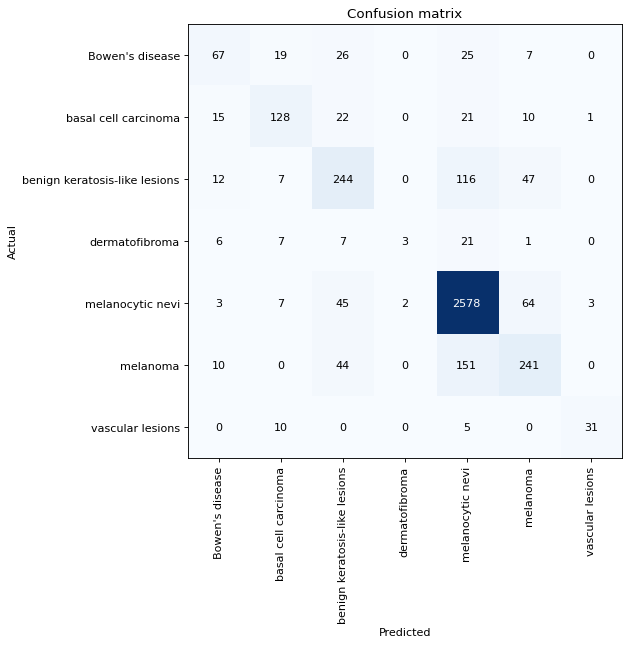

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

In [26]:
learn.fit_one_cycle(5,lr_max=lrs.minimum)


epoch,train_loss,valid_loss,accuracy,time
0,0.854360,1.114054,0.703195,05:02
1,0.793509,0.799118,0.733899,05:07
2,0.758993,3499.666504,0.672491,05:01
3,0.682975,0.675089,0.746880,04:57
4,0.642069,0.599695,0.785821,05:02


In [27]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

                               precision    recall  f1-score   support

              Bowen's disease       0.57      0.31      0.40       144
         basal cell carcinoma       0.57      0.58      0.57       197
benign keratosis-like lesions       0.55      0.46      0.50       426
               dermatofibroma       0.50      0.04      0.08        45
             melanocytic nevi       0.85      0.95      0.90      2702
                     melanoma       0.61      0.41      0.49       446
             vascular lesions       0.76      0.63      0.69        46

                     accuracy                           0.79      4006
                    macro avg       0.63      0.48      0.52      4006
                 weighted avg       0.76      0.79      0.77      4006



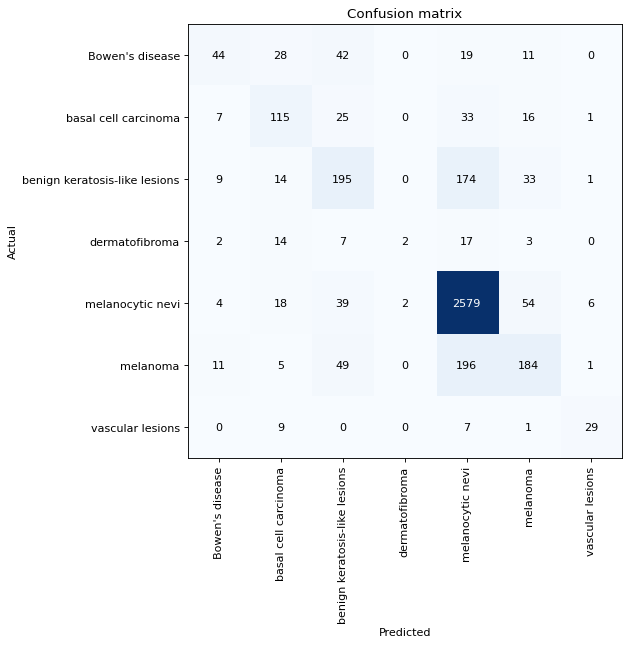

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

In [30]:

def predict(imgpath):
    display(PILImage.create(imgpath).to_thumb(350,350))
    pred,idx,probs = learn.predict(PILImage.create(imgpath))
    print(f"This is a: {pred}, with probability {probs[idx]:.4f}.")

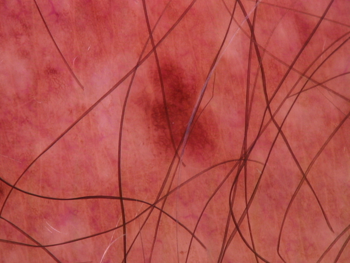

This is a: melanocytic nevi, with probability 0.9997.


In [32]:
predict("/content/HAM10000_images_part_1/ISIC_0024491.jpg")


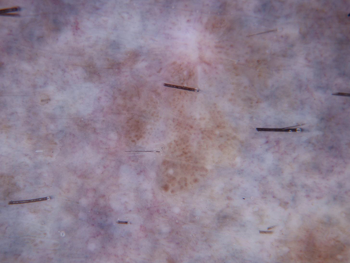

This is a: benign keratosis-like lesions, with probability 0.8369.


In [37]:
predict("/content/HAM10000_images_part_1/ISIC_0024446.jpg")
